In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# dataset used
df2 = pd.read_csv("0.001percent_2classes.csv")
df8 = pd.read_csv("0.001percent_8classes.csv")
df34 = pd.read_csv("0.001percent_34classes.csv")


filter_vars = ["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance"]
label_vars = ["label", "benign"]

to_filter = filter_vars + label_vars

df2 = df2.filter(items=to_filter)
df8 = df8.filter(items=to_filter)
df34 = df34.filter(items=to_filter)

In [3]:
# creating dataframes to store result metrics
columns = ["Logistic Regression","KNN","Random Forest"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

In [4]:
def split(df_name):
    if df_name == "df2":
        label = "benign"
        df = df2.sample(n=16000, random_state=42)
    else:
        label = "label"
        if df_name == "df8": df = df8.sample(n=16000, random_state=42)
        else: df = df34.sample(n=16000, random_state=42)
    
    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]
    
    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)
    
    # encoding for XGBoost
    # encoder = LabelEncoder()
    # encoded_y_train = encoder.fit_transform(y_train)
    # encoded_y_test = encoder.fit_transform(y_test)
    
    return scaled_X_train, scaled_X_test, y_train, y_test

In [5]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 6:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [6]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, y_test, target_names, classes, model_name):
    
    pred = model.predict(scaled_X_test)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])
    
    print(classification_report(y_test, pred, digits = 3))
    
    if classes == 2 or classes == 8:
        plt.figure(figsize = (4, 2), dpi = 300)
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2), 
                               display_labels = target_names).plot()
        plt.xticks(rotation=90);

In [7]:
def get_weights(y_train):
    import math
    
    # Get counts in log10
    y_train_count = y_train.value_counts()
    y_log = y_train_count.apply(lambda x: math.log10(x))
    
    # Find the factor needed to bring minority classes to majority
    y_log_max = y_log.max()
    y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))
    
    weight_dict = y_log.to_dict()
    
    return weight_dict

In [8]:
target_names = ["Attack", "Benign"]

Logistic Regression Model for 2 classes : Attack and Benign
              precision    recall  f1-score   support

       False      0.991     0.994     0.992      3125
        True      0.701     0.627     0.662        75

    accuracy                          0.985      3200
   macro avg      0.846     0.810     0.827      3200
weighted avg      0.984     0.985     0.985      3200

K-nearest neighbors Model for 2 classes : Attack and Benign
              precision    recall  f1-score   support

       False      0.995     0.994     0.994      3125
        True      0.756     0.787     0.771        75

    accuracy                          0.989      3200
   macro avg      0.876     0.890     0.883      3200
weighted avg      0.989     0.989     0.989      3200

Random Forest Model for 2 classes : Attack and Benign
              precision    recall  f1-score   support

       False      0.986     0.998     0.992      3125
        True      0.838     0.413     0.554        75

    accu

<Figure size 1200x600 with 0 Axes>

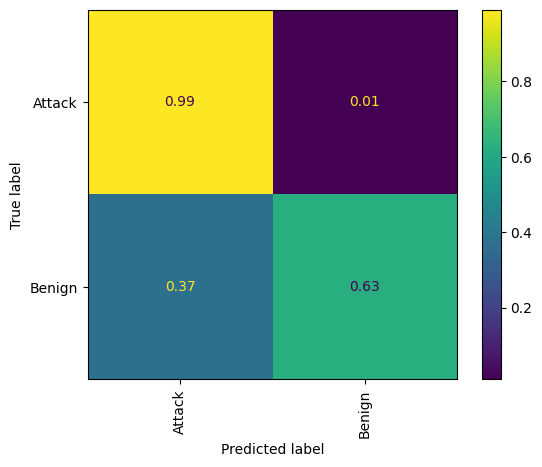

<Figure size 1200x600 with 0 Axes>

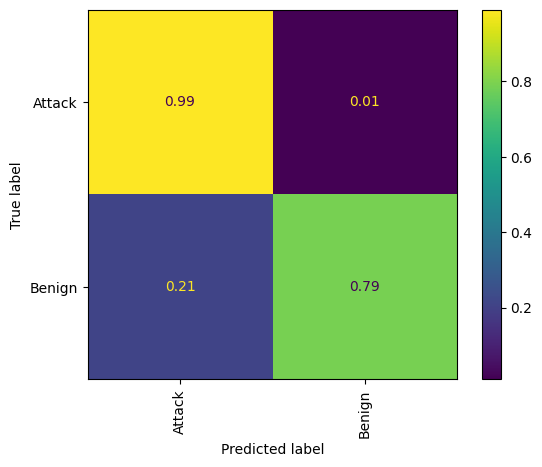

<Figure size 1200x600 with 0 Axes>

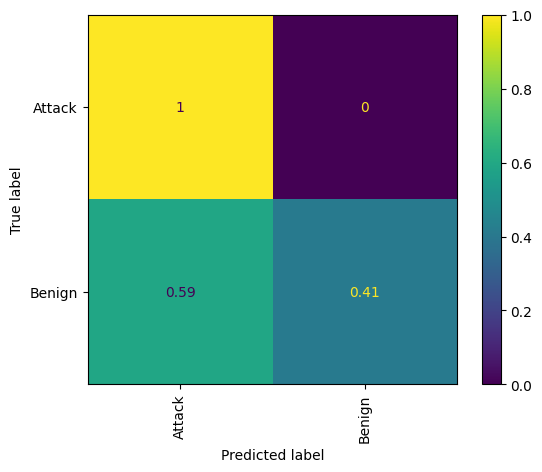

In [9]:
scaled_X_train, scaled_X_test, y_train, y_test = split("df2")
weight_dict = get_weights(y_train)
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)
print("Logistic Regression Model for 2 classes : Attack and Benign")
evaluate(logreg_model, y_test, target_names, 2, "Logistic Regression")

knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(scaled_X_train, y_train)
print("K-nearest neighbors Model for 2 classes : Attack and Benign")
evaluate(knn, y_test, target_names, 2, "KNN")

# Base RF
randomforest_model = RandomForestClassifier(n_estimators=100)
randomforest_model.fit(scaled_X_train, y_train)
print("Random Forest Model for 2 classes : Attack and Benign")
evaluate(randomforest_model, y_test, target_names, 2, "Random Forest")

In [10]:
metrics_2

Logistic Regression       KNN Random Forest
Accuracy                0.985  0.989062      0.984375
Recall               0.810133  0.890293      0.705707
Precision            0.846278  0.875643      0.911963
F1-Score             0.827151   0.88282       0.77281

In [11]:
scaled_X_train, scaled_X_test, y_train, y_test = split("df8")
weight_dict = get_weights(y_train)
y_train.value_counts()
target_names = ["Benign", "DDoS", "Dos", "Mirai", "Recon", "Spoofing"]
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)
print("Logistic Regression Model for 6 classes")
evaluate(logreg_model, y_test, target_names, 6, "Logistic Regression")

knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(scaled_X_train, y_train)
print("K-nearest neighbors Model for 6 classes")
evaluate(knn, y_test, target_names, 6, "KNN")

# Base RF
randomforest_model = RandomForestClassifier(n_estimators=100)
randomforest_model.fit(scaled_X_train, y_train)
print("Random Forest Model for 6 classes")
evaluate(randomforest_model, y_test, target_names, 6, "Random Forest")


Logistic Regression Model for 6 classes
              precision    recall  f1-score   support

      Benign      0.626     0.816     0.709        76
        DDoS      0.829     0.993     0.904      2330
         DoS      0.748     0.139     0.234       555
       Mirai      0.989     0.989     0.989       180
       Recon      0.200     0.095     0.129        21
    Spoofing      0.500     0.237     0.321        38

    accuracy                          0.825      3200
   macro avg      0.649     0.545     0.548      3200
weighted avg      0.811     0.825     0.776      3200

K-nearest neighbors Model for 6 classes
              precision    recall  f1-score   support

      Benign      0.636     0.895     0.743        76
        DDoS      0.850     0.982     0.911      2330
         DoS      0.790     0.277     0.411       555
       Mirai      0.989     0.978     0.983       180
       Recon      0.231     0.143     0.176        21
    Spoofing      0.625     0.263     0.370        3

In [12]:
metrics_8

Logistic Regression       KNN Random Forest
Accuracy             0.825313  0.843437      0.813125
Recall                 0.5447  0.589664      0.648467
Precision            0.648626  0.686672      0.688027
F1-Score              0.54758  0.599215      0.640739

In [13]:
scaled_X_train, scaled_X_test, y_train, y_test = split("df34")
weight_dict = get_weights(y_train)
y_train.value_counts()
target_names = list(y_test.unique())
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)
print("Logistic Regression Model for 23 classes")
evaluate(logreg_model, y_test, target_names, 23, "Logistic Regression")

knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(scaled_X_train, y_train)
print("K-nearest neighbors Model for 23 classes")
evaluate(knn, y_test, target_names, 23, "KNN")

# Base RF
randomforest_model = RandomForestClassifier(n_estimators=100)
randomforest_model.fit(scaled_X_train, y_train)
print("Random Forest Model for 23 classes")
evaluate(randomforest_model, y_test, target_names, 23, "Random Forest")

Logistic Regression Model for 23 classes
                         precision    recall  f1-score   support

          BenignTraffic      0.688     0.733     0.710        75
 DDoS-ACK_Fragmentation      1.000     0.105     0.190        19
        DDoS-ICMP_Flood      0.969     0.996     0.982       496
DDoS-ICMP_Fragmentation      0.596     1.000     0.747        28
      DDoS-PSHACK_Flood      0.989     0.986     0.988       282
       DDoS-RSTFINFlood      1.000     0.996     0.998       279
         DDoS-SYN_Flood      0.667     0.957     0.786       279
DDoS-SynonymousIP_Flood      0.867     0.684     0.765       247
         DDoS-TCP_Flood      0.655     0.964     0.780       309
         DDoS-UDP_Flood      0.727     0.904     0.806       374
 DDoS-UDP_Fragmentation      0.882     0.789     0.833        19
           DNS_Spoofing      0.222     0.143     0.174        14
         DoS-HTTP_Flood      0.000     0.000     0.000         1
          DoS-SYN_Flood      0.721     0.353    

C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\U

                         precision    recall  f1-score   support

          BenignTraffic      0.683     0.920     0.784        75
 DDoS-ACK_Fragmentation      0.400     0.211     0.276        19
        DDoS-ICMP_Flood      0.959     0.992     0.975       496
DDoS-ICMP_Fragmentation      0.565     0.929     0.703        28
      DDoS-PSHACK_Flood      0.496     0.996     0.662       282
       DDoS-RSTFINFlood      1.000     0.993     0.996       279
         DDoS-SYN_Flood      0.443     0.237     0.308       279
DDoS-SynonymousIP_Flood      0.378     0.684     0.487       247
         DDoS-TCP_Flood      0.565     0.269     0.364       309
         DDoS-UDP_Flood      0.736     0.955     0.831       374
 DDoS-UDP_Fragmentation      0.929     0.684     0.788        19
           DNS_Spoofing      0.300     0.214     0.250        14
         DoS-HTTP_Flood      1.000     1.000     1.000         1
          DoS-SYN_Flood      0.662     0.309     0.422       139
          DoS-TCP_Flood 

C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\U

In [14]:
metrics_34

Logistic Regression       KNN Random Forest
Accuracy             0.801562  0.677188      0.550937
Recall               0.576784  0.557046      0.439573
Precision            0.641869  0.616401      0.459452
F1-Score             0.569364  0.548734      0.399994

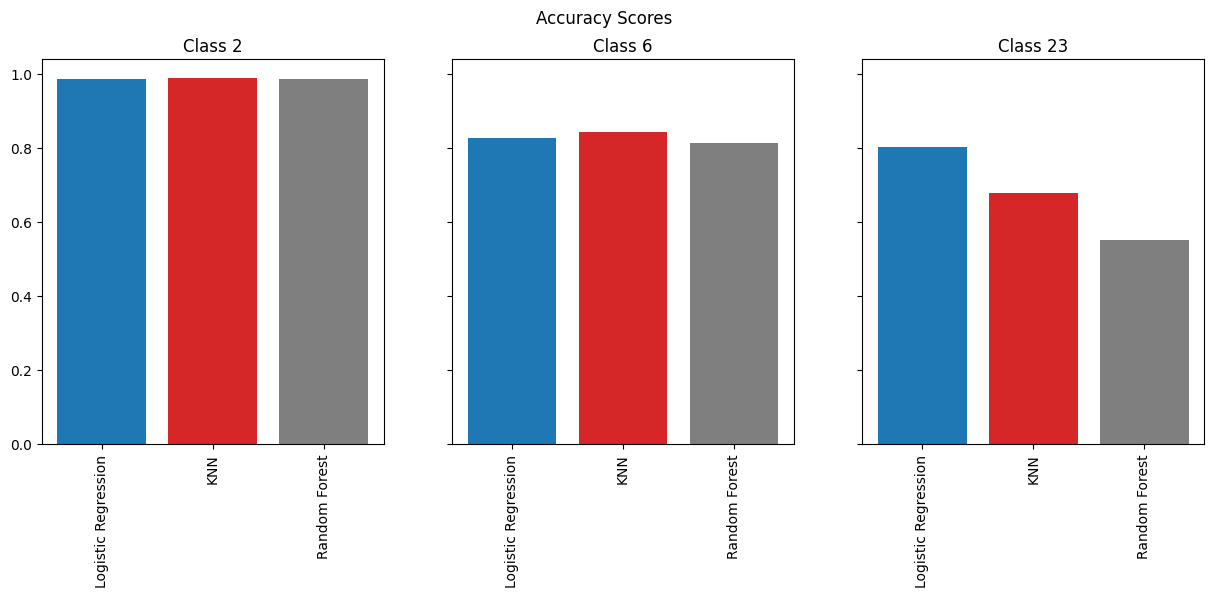

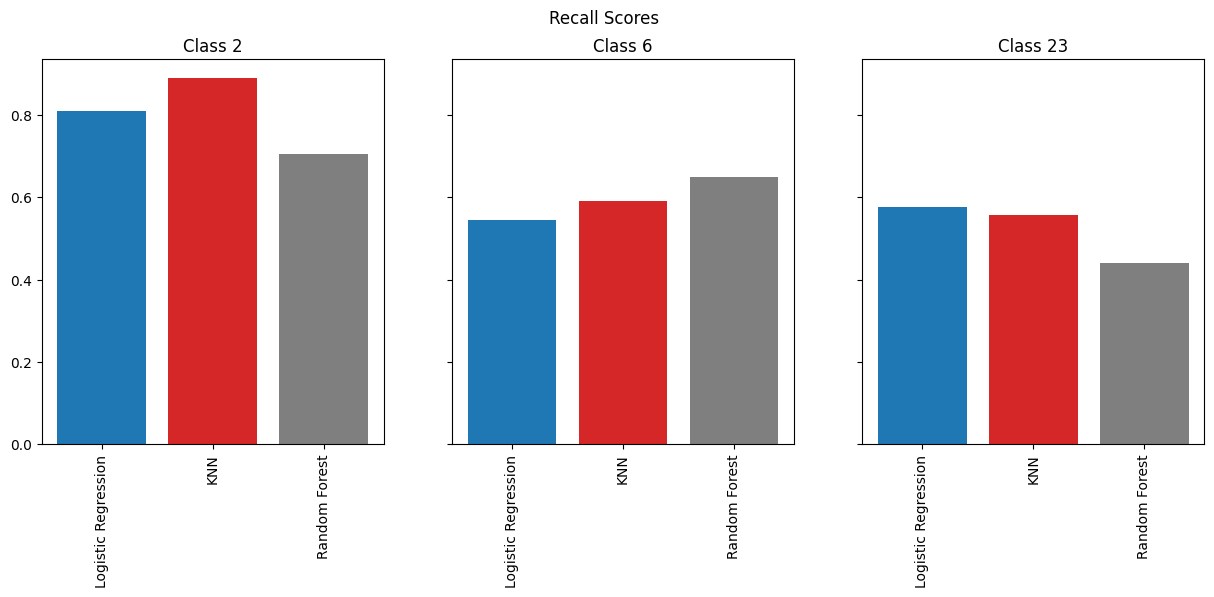

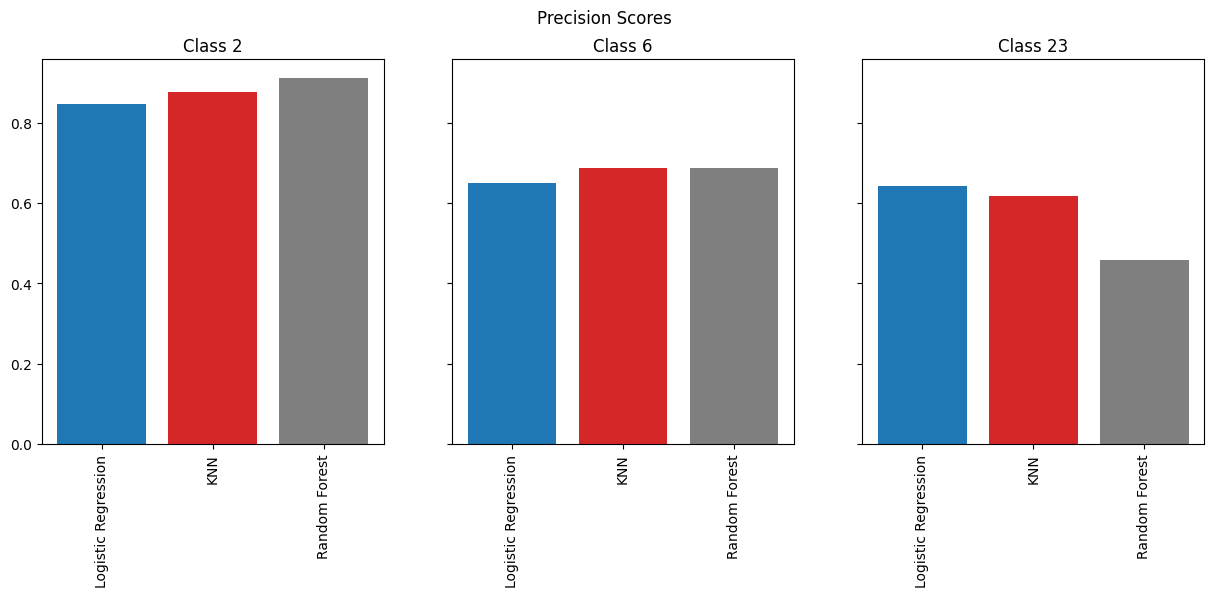

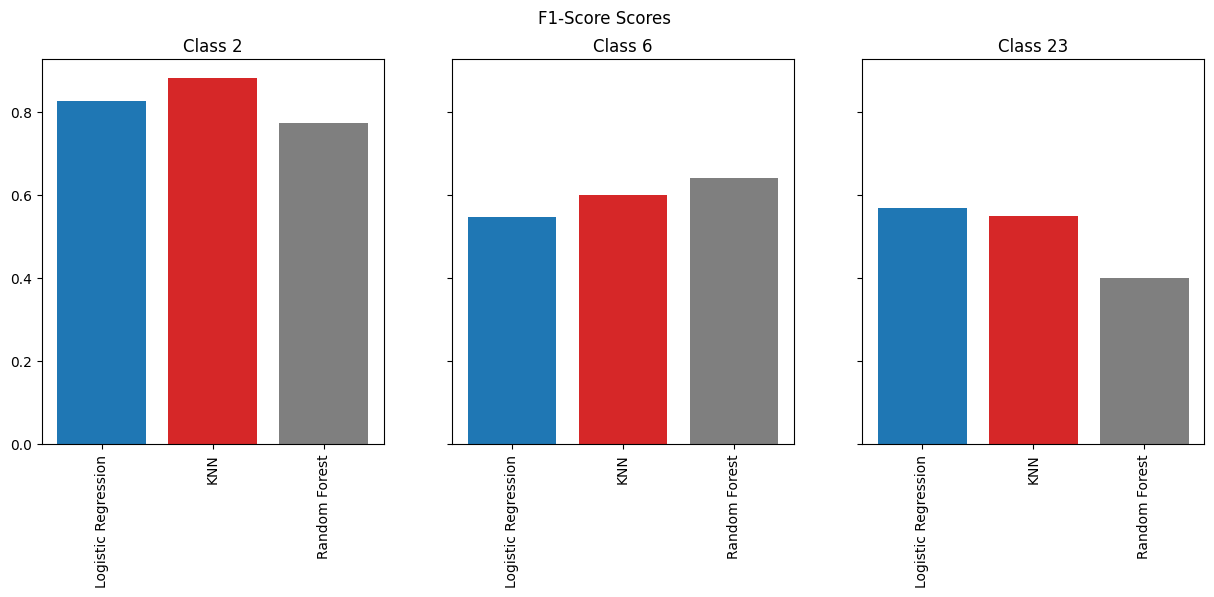

In [15]:
# List of model names
model_names = ["Logistic Regression", "KNN","Random Forest"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 6, 23]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "KNN": 'tab:red',
    "Random Forest": 'tab:gray',
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")
        
        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)
        
        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=90)
    
    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')
    
    plt.show()

In [16]:
# Concatenate them along rows
concatenated_data = pd.concat([metrics_2, metrics_8, metrics_34], ignore_index=False)
# List of model names
model_names = ["Logistic Regression", "KNN", "Random Forest"]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a DataFrame with the concatenated data
result_df = pd.DataFrame(concatenated_data.values,
                          pd.MultiIndex.from_product([["2 classes", "8 classes", "34 classes"], metrics]),
                          columns=model_names)

# Display the result
result_df

Logistic Regression       KNN Random Forest
2 classes  Accuracy                0.985  0.989062      0.984375
           Recall               0.810133  0.890293      0.705707
           Precision            0.846278  0.875643      0.911963
           F1-Score             0.827151   0.88282       0.77281
8 classes  Accuracy             0.825313  0.843437      0.813125
           Recall                 0.5447  0.589664      0.648467
           Precision            0.648626  0.686672      0.688027
           F1-Score              0.54758  0.599215      0.640739
34 classes Accuracy             0.801562  0.677188      0.550937
           Recall               0.576784  0.557046      0.439573
           Precision            0.641869  0.616401      0.459452
           F1-Score             0.569364  0.548734      0.399994

In [18]:
df = df34
df

duration  srate  drate  syn_flag_number  psh_flag_number  \
0          64.0      2    0.0            False            False   
1          64.0      0    0.0             True            False   
2         166.6    222    0.0            False            False   
3          64.0      5    0.0            False            False   
4          64.0      0    0.0             True            False   
...         ...    ...    ...              ...              ...   
16054      64.0      4    0.0            False            False   
16055      64.0      6    0.0            False             True   
16056      64.0     27    0.0            False            False   
16057      64.0     73    0.0            False            False   
16058      64.0      0    0.0            False            False   

       ack_flag_number  ack_count  syn_count  rst_count  header_length  ...  \
0                False        1.0       0.00          0             54  ...   
1                False        0.0       2.40          0            129  ...   
2                 True        0.0       1.80        503         598737  ...   
3                False        0.0       0.00          0             54  ...   
4                False        0.0       1.98          0            109  ...   
...                ...        ...        ...        ...            ...  ...   
16054            False        0.0       0.00          0              2  ...   
16055             True        0.0       0.00          1             54  ...   
16056            False        0.0       0.00          0              0  ...   
16057            False        0.0       0.00          0             54  ...   
16058            False        0.0       0.00          0             54  ...   

       flow_duration         avg      max  tot_sum    min           iat  \
0           0.000000    54.00000    54.00   567.00   54.0  8.334093e+07   
1           3.638290    54.00000    54.00   567.00   54.0  8.336534e+07   
2           2.265698  1138.67190  1514.00  5314.70  645.2  3.215217e-03   
3           0.000000    54.00000    54.00   567.00   54.0  8.307602e+07   
4           5.362558    54.34776    59.20   572.20   54.0  8.298166e+07   
...              ...         ...      ...      ...    ...           ...   
16054       0.000000    43.20583    49.20   455.40   42.0  8.312771e+07   
16055       0.000000    54.00000    54.00   567.00   54.0  8.333178e+07   
16056       0.000000    42.00000    42.00   441.00   42.0  8.312484e+07   
16057       0.000000    54.00000    54.00   567.00   54.0  8.294705e+07   
16058       0.000000    54.13773    55.68   568.68   54.0  8.295583e+07   

       magnitude      radius  variance                    label  
0      10.392304    0.000000      0.00         DDoS-RSTFINFlood  
1      10.392304    0.000000      0.00  DDoS-SynonymousIP_Flood  
2      47.153050  578.696700      0.60            BenignTraffic  
3      10.392304    0.000000      0.00           DDoS-TCP_Flood  
4      10.425356    1.831365      0.10            DoS-SYN_Flood  
...          ...         ...       ...                      ...  
16054   9.288337    3.708531      0.15          DDoS-ICMP_Flood  
16055  10.392304    0.000000      0.00        DDoS-PSHACK_Flood  
16056   9.165152    0.000000      0.00          DDoS-ICMP_Flood  
16057  10.392304    0.000000      0.00            DoS-TCP_Flood  
16058  10.405521    0.642377      0.14            DoS-TCP_Flood  

[16059 rows x 22 columns]

In [19]:
label = "label"

In [20]:
# Sorting our dataset into features and target
X = df.drop(label, axis = 1)
y = df[label]

# splitting out dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# scaling our features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

In [21]:
# Logistic regression
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)
# Evaluate the model
y_pred = logreg_model.predict(scaled_X_test)
accuracy = accuracy_score(y_test, y_pred)
#report
classification_report_output = classification_report(y_test, y_pred)
print(classification_report_output)

                         precision    recall  f1-score   support

          BenignTraffic       0.68      0.93      0.79        75
 DDoS-ACK_Fragmentation       1.00      0.11      0.19        19
        DDoS-ICMP_Flood       0.97      1.00      0.98       498
DDoS-ICMP_Fragmentation       0.52      0.93      0.67        28
      DDoS-PSHACK_Flood       1.00      0.98      0.99       283
       DDoS-RSTFINFlood       1.00      1.00      1.00       280
         DDoS-SYN_Flood       0.65      0.98      0.78       281
DDoS-SynonymousIP_Flood       0.69      0.66      0.67       248
         DDoS-TCP_Flood       0.76      0.90      0.83       310
         DDoS-UDP_Flood       0.68      0.98      0.80       375
 DDoS-UDP_Fragmentation       0.91      0.53      0.67        19
           DNS_Spoofing       0.50      0.14      0.22        14
         DoS-HTTP_Flood       0.00      0.00      0.00         1
          DoS-SYN_Flood       0.53      0.06      0.10       140
          DoS-TCP_Flood 

C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Random forest
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_model.fit(scaled_X_train, y_train)
# Evaluate the model
y_pred = rfc_model.predict(scaled_X_test)
accuracy = accuracy_score(y_test, y_pred)
#report
classification_report_output = classification_report(y_test, y_pred)
print(classification_report_output)

                         precision    recall  f1-score   support

          BenignTraffic       0.68      0.55      0.61        75
 DDoS-ACK_Fragmentation       1.00      0.11      0.19        19
        DDoS-ICMP_Flood       0.50      0.00      0.01       498
DDoS-ICMP_Fragmentation       1.00      0.04      0.07        28
      DDoS-PSHACK_Flood       0.49      1.00      0.66       283
       DDoS-RSTFINFlood       1.00      1.00      1.00       280
         DDoS-SYN_Flood       0.66      0.98      0.79       281
DDoS-SynonymousIP_Flood       0.97      0.99      0.98       248
         DDoS-TCP_Flood       0.04      0.03      0.03       310
         DDoS-UDP_Flood       0.35      1.00      0.52       375
 DDoS-UDP_Fragmentation       0.30      0.89      0.45        19
           DNS_Spoofing       0.28      0.50      0.36        14
         DoS-HTTP_Flood       0.00      0.00      0.00         1
          DoS-SYN_Flood       0.00      0.00      0.00       140
          DoS-TCP_Flood 

C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# K-nearest neighbours
knn_model = KNeighborsClassifier(n_neighbors = 2)
knn_model.fit(scaled_X_train, y_train)
# Evaluate the model
y_pred = knn_model.predict(scaled_X_test)
accuracy = accuracy_score(y_test, y_pred)
#report
classification_report_output = classification_report(y_test, y_pred)
print(classification_report_output)

                         precision    recall  f1-score   support

          BenignTraffic       0.70      0.92      0.79        75
 DDoS-ACK_Fragmentation       0.42      0.79      0.55        19
        DDoS-ICMP_Flood       0.96      0.99      0.98       498
DDoS-ICMP_Fragmentation       0.62      0.36      0.45        28
      DDoS-PSHACK_Flood       0.50      1.00      0.67       283
       DDoS-RSTFINFlood       1.00      0.99      1.00       280
         DDoS-SYN_Flood       0.64      0.94      0.77       281
DDoS-SynonymousIP_Flood       0.74      0.70      0.72       248
         DDoS-TCP_Flood       0.51      0.28      0.36       310
         DDoS-UDP_Flood       0.73      0.90      0.81       375
 DDoS-UDP_Fragmentation       1.00      0.58      0.73        19
           DNS_Spoofing       0.44      0.29      0.35        14
         DoS-HTTP_Flood       0.00      0.00      0.00         1
          DoS-SYN_Flood       0.85      0.16      0.28       140
          DoS-TCP_Flood 

C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Bhara\Anaconda3\envs\deciot\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
